Logistic Regression Problem
\begin{equation}
\begin{array}{cl}
\displaystyle\min_{x\in \mathbb{R}^n} & \tfrac{1}{m} \displaystyle\sum_{i=1}^m \ln \left(1 + \exp \left(-y_i x^\top a_i \right)\right) \\
\mathrm{s.t.} & \|x\|_1 \leq \tau,
\end{array}
\end{equation}


In [2]:
# Load required packages
required_packages = ["DataFrames","LinearAlgebra","Statistics", "MAT","Random", "Plots","Zygote", "Measures", "PyPlot","CSV","Arpack","Downloads","SparseArrays","LIBSVM","LIBSVMdata"]
for pkg in required_packages
    try
        eval(Meta.parse("using $pkg"))
    catch e
        @warn "$pkg not found, installing..."
        import Pkg
        Pkg.add(pkg)
        eval(Meta.parse("using $pkg"))
    end
end

In [3]:
#______________________________________________________________________________#
#             After switching to "Julia" kernel, run this cell                 #
#______________________________________________________________________________#
using DataFrames
using LinearAlgebra
using Statistics
using MAT
using Random
using Plots
using Zygote
using Measures
using PyPlot
using CSV
using Arpack
using Downloads
using SparseArrays
using LIBSVM
#______________________________________________________________________________#

#_________________________________setting problem______________________________#
#                --- Lasso Problem Data: Logistic Regression Problem ---                   #
#______________________________________________________________________________#
# Set random seed for reproducibility
Random.seed!(23)
tau = 50
# Function to parse LIBSVM format from a file
using LIBSVMdata
 A, y = load_dataset("a1a",
     dense   = false,
     replace = false,
     verbose = true,
 )
 m = size(A, 1)
n = size(A, 2)
# Define logistic loss function
f(x)= mean(log.(1 .+ exp.(-y .* (A * x))))
# Gradient via automatic differentiation
grad_f(x) = Zygote.gradient(f, x)[1]

# Lipschitz constant estimation
L = opnorm(Matrix(A))^2 / (4 * m)  # Convert to dense matrix for 2-norm
println("Lipschitz constant (L): $L")

# Initial point (sparse vector)
V = vcat(tau * I(n), -tau * I(n))
x0 = V[rand(1:size(V, 1)), :]

# Linear Minimization Oracle (LMO)
function lmo(g)
    i = argmax(abs.(g))
    return -tau * sign(g[i]) * [i == j ? 1.0 : 0.0 for j in 1:n]
end
#
max_iter = 3000

# Save data to .mat file
# Define output directory
output_dir = "/content/output"
mkpath(output_dir)  # Create directory if it doesn't exist
matwrite(joinpath(output_dir, "data.mat"), Dict(
    "m" => n,
    "n" => n,
    "A" => Matrix(A),
    "x0" => x0,
    "L" => L,
    "max_iter" => max_iter
))

println("Saved: ", joinpath(output_dir, "data.mat"))
#______________________________________________________________________________#

* Couldn't find host www.csie.ntu.edu.tw in the .netrc file; using defaults
* Host www.csie.ntu.edu.tw:443 was resolved.
* IPv6: (none)
* IPv4: 140.112.30.26
*   Trying 140.112.30.26:443...
* Connected to www.csie.ntu.edu.tw (140.112.30.26) port 443
* mbedTLS: Connecting to www.csie.ntu.edu.tw:443
* mbedTLS: Set min SSL version to TLS 1.0
* ALPN: curl offers h2,http/1.1
* mbedTLS: Handshake complete, cipher is TLS-ECDHE-RSA-WITH-AES-128-GCM-SHA256
* Dumping cert info: * cert. version     : 3
* serial number     : 47:E8:00:00:00:07:87:FE:49:35:DC:01:F3:CD:23:5B
* issuer name       : C=TW, O=TAIWAN-CA, CN=TWCA Secure SSL Certification Authority
* subject name      : C=TW, ST=Taiwan, L=Taipei, O=National Taiwan University, CN=*.csie.ntu.edu.tw
* issued  on        : 2024-10-16 09:35:59
* expires on        : 2025-11-03 15:59:59
* signed using      : RSA with SHA-256
* RSA key size      : 2048 bits
* basic constraints : CA=false
* subject alt name  :
*     dNSName : *.csie.ntu.edu.tw
*     d

Loading the dataset...


* Connection #0 to host www.csie.ntu.edu.tw left intact
0.0%┣                                             ┫ 0/1.6k [00:00<00:00, -0s/it]


Lipschitz constant (L): 1.5671575180453337


0.1%┣                                         ┫ 1/1.6k [00:00<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████┫ 1.6k/1.6k [00:00<00:00, 3.3kit/s]
100.0%┣██████████████████████████████████████┫ 1.6k/1.6k [00:00<00:00, 3.3kit/s]


Saved: /content/output/data.mat


In [4]:
# Ensure all necessary packages are loaded
using DataFrames
using LinearAlgebra
using Statistics
using MAT
using Random
using Plots
using Zygote
using Measures
using PyPlot
using CSV
using Arpack
using Downloads
using SparseArrays
using LIBSVM
#______________________________________________________________________________#
#__________________________________Main Functions______________________________#
#______________________________________________________________________________#

#___________ __FW: Adaptive step-size with constant scalling___________________#
function conditional_gradient_adaptive(f, grad_f, lmo, x0, max_iter, gamma; epsilon=1e-5, delta=1e-10, beta=2)
    println("\e[34m________Adaptive step-size: with constant scalling_________")
    x_prev = copy(x0)
    x_curr = copy(x0)
    values = [f(x_curr)]
    times = [0.0]
    gaps = Float64[]
    L_ks = Float64[]
    steps = Float64[]
    backtrack_counts = Int[]
    k = 0
    prev_grad = grad_f(x_prev)
    current_f = f(x_curr)
    while k < max_iter
        start = time()    # start time
        current_grad = grad_f(x_curr)
        v = lmo(current_grad)
        d = v - x_curr
        normd2 = dot(d, d)
        gap = -dot(current_grad, d)
        if gap <= epsilon
            println(">>>  ____________________     Terminated at k=$k, Dual Gap: $(round(gap, digits=4))____________________")
            iteration_time = time() - start #  record final time
            push!(times, iteration_time)      #  save final time
            push!(gaps, gap)
            break
        end
        if k == 0
            Random.seed!(23)
            d0 = randn(length(x0))
            L_k = gamma * ((norm(grad_f(x0) - grad_f(x0 + 1e-3 * d0)) / (1e-3 * norm(d0))) + delta)
        else
            grad_diff = norm(current_grad - prev_grad)
            x_diff = norm(x_curr - x_prev)
            L_k = gamma * ((grad_diff / x_diff) + delta)
        end
        Lknormd2 = L_k * normd2
        t_k = min(gap / Lknormd2, 1.0)
        i = 0
        while true
            x_new = x_curr + t_k * d
            new_f = f(x_new)
            if current_f - new_f >= t_k * gap - (Lknormd2 / 2) * t_k^2
                x_prev = copy(x_curr)
                x_curr = x_new
                push!(backtrack_counts, i)
                break
            else
                L_k *= beta
                Lknormd2 = L_k * normd2
                t_k = min(gap / Lknormd2, 1.0)
                i += 1
            end
        end
        k += 1
        iteration_time = time() - start  # time end

        current_f = f(x_curr)
        prev_grad = current_grad
        push!(gaps, gap)
        push!(steps, t_k)
        push!(values, current_f)
        push!(times, iteration_time)
        push!(L_ks, L_k)
        if k % 100 == 0   # Print progress only every 100 iterations
            println("k $k: Dual Gap = $(round(gap, digits=4)), t_k = $(round(t_k, digits=6)), L_k = $(round(L_k, digits=6)), Time = $(round(iteration_time, digits=4)) sec, f_k = $(round(current_f, digits=6))")
        end
    end
    println("k $k: Dual Gap = $(round(gaps[end], digits=4)), t_k = $(round(steps[end], digits=6)), L_k = $(round(L_ks[end], digits=6)), Time = $(round(times[end], digits=4)) sec, f_k = $(round(values[end], digits=6))")
    total_time = sum(times)
    println("Adaptive Method (γ=$gamma):")
    println(">Total time: $(round(total_time, digits=4)) seconds")
    println("Total backtracking steps: $(sum(backtrack_counts))")
    println(">Total iterations: $k")
    println(">Objective value: $(round(current_f, digits=6))")
    println("Max L_k: $(round(maximum(L_ks), digits=6))")
    println("Max L_k 2: $(round(maximum(L_ks[2:end]), digits=6))")
    println("Mean L_k: $(round(mean(L_ks), digits=6))")
    println("Mean L_k 2: $(round(mean(L_ks[2:end]), digits=6))")
    println("____________________________________________________________\e[0m")
    return (x_curr, values, times, gaps, L_ks, backtrack_counts, steps)
end
#______________________________________________________________________________#
#____________FW: Adaptive step-size with adjustable scalling___________________#
function conditional_gradient_adjustable_scaling(f, grad_f, lmo, x0, max_iter, gamma; epsilon=1e-5, delta=1e-10, beta=2)
    println("\e[33m_____________________Adaptive step-size with adjustable scalling_____________________")
    x_prev = copy(x0)
    x_curr = copy(x0)
    values = [f(x_curr)]
    times = [0.0]
    gaps = Float64[]
    L_ks = Float64[]
    steps = Float64[]
    backtrack_counts = Int[]
    gamma_history = [gamma]  # Track gamma over iterations
    k = 0
    prev_grad = grad_f(x_prev)
    current_f = f(x_curr)
    recent_backtracks = Int[]  # Store backtracking counts for the last 10 iterations

    while k < max_iter
        start = time()  #start time
        current_grad = grad_f(x_curr)
        v = lmo(current_grad)
        d = v - x_curr
        normd2 = dot(d, d)
        gap = -dot(current_grad, d)

        if gap <= epsilon
            println(">>> ____________________      Terminated at k=$k, Dual Gap: $(round(gap, digits=4))  ____________________")
            iteration_time = time() - start #  record final time
            push!(times, iteration_time)      #  save final time
            push!(gaps, gap)
            break
        end
        if k == 0
            Random.seed!(23)
            d0 = randn(length(x0))
            L_k = gamma * ((norm(grad_f(x0) - grad_f(x0 + 1e-3 * d0)) / (1e-3 * norm(d0))) + delta)
        else
            grad_diff = norm(current_grad - prev_grad)
            x_diff = norm(x_curr - x_prev)
            L_k = gamma * ((grad_diff / x_diff) + delta)
        end
        Lknormd2 = L_k * normd2
        t_k = min(gap / Lknormd2, 1.0)
        i = 0
        while true
            x_new = x_curr + t_k * d
            new_f = f(x_new)
            if current_f - new_f >= t_k * gap - (Lknormd2 / 2) * t_k^2
                x_prev = copy(x_curr)
                x_curr = x_new
                push!(backtrack_counts, i)
                push!(recent_backtracks, i)
                break
            else
                L_k *= beta
                Lknormd2 = L_k * normd2
                t_k = min(gap / Lknormd2, 1.0)
                i += 1
            end
        end


        # Adaptive gamma adjustment every 10 iterations
        if k % 10 == 0 && k > 0
            total_backtracks = sum(recent_backtracks)
            if total_backtracks == 0
                gamma =  gamma * 0.9  # Decrease gamma, with a lower bound
             #   println(">> k $k: No backtracking, >> reducing gamma to $(round(gamma, digits=4))")
            elseif total_backtracks > 10
                gamma =min(1,gamma * 1.1)  # Increase gamma, with an upper bound
            #    println("<< k $k: ($total_backtracks) backtracking, << increasing gamma to $(round(gamma, digits=4))")
            end
            push!(gamma_history, gamma)
            recent_backtracks = Int[]  # Reset for the next 10 iterations
        elseif k % 10 == 0
            push!(gamma_history, gamma)
            recent_backtracks = Int[]
        else
            push!(recent_backtracks, i)
        end
        k += 1
        iteration_time = time() - start   #end time


        current_f = f(x_curr)
        prev_grad = current_grad
        push!(gaps, gap)
        push!(steps, t_k)
        push!(values, current_f)
        push!(times, iteration_time)
        push!(L_ks, L_k)

        if k % 100 == 0
            println("k $k: Dual Gap = $(round(gap, digits=4)), t_k = $(round(t_k, digits=6)), L_k = $(round(L_k, digits=6)), Time = $(round(iteration_time, digits=4)) sec, f_k = $(round(current_f, digits=6))")
        end
    end
    println("k $k: Dual Gap = $(round(gaps[end], digits=4)), t_k = $(round(steps[end], digits=6)), L_k = $(round(L_ks[end], digits=6)), Time = $(round(times[end], digits=4)) sec, f_k = $(round(values[end], digits=6))")
    total_time = sum(times)
    println("Adaptive Method (final γ=$(round(gamma, digits=4))):")
    println(">Total time: $(round(total_time, digits=4)) seconds")
    println("Total backtracking steps: $(sum(backtrack_counts))")
    println(">Total iterations: $k")
    println(">Objective value: $(round(current_f, digits=6))")
    println("Max L_k: $(round(maximum(L_ks), digits=6))")
    println("Mean L_k: $(round(mean(L_ks), digits=6))")
    println("____________________________________________________________\e[0m")
    return (x_curr, values, times, gaps, L_ks, backtrack_counts, steps, gamma_history)
end
#______________________________________________________________________________#
#___________________________FW: Pedregosa et al. step-size_____________________#
function conditional_gradient_Pedregosa(f, grad_f, lmo, x0, max_iter; epsilon=1e-5)
    println("\e[31m_____________________Pedregosa et al. step-size_____________")
    x_prev = copy(x0)
    values = [f(x_prev)]
    times = [0.0]
    gaps = Float64[]
    L_ks = Float64[]
    steps = Float64[]
    backtrack_counts = Int[]
    k = 0
    tau = 2.0
    eta = 0.9
    Random.seed!(23)
    d0 = randn(length(x0))
    L_minus1 = norm(grad_f(x0) - grad_f(x0 + 1e-3 * d0)) / (1e-3 * norm(d0))
    M = L_minus1 * eta
    while k < max_iter
        start = time()   # start time
        grad = grad_f(x_prev)
        v = lmo(grad)
        d = v - x_prev
        normd2 = norm(d)^2
        gap = -dot(grad, d)

        f_prev = f(x_prev)
        if gap <= epsilon
            println(">>>  ____________________     Terminated at k=$k, Dual Gap: $(round(gap, digits=4))   ____________________")
            iteration_time = time() - start #  record final time
            push!(times, iteration_time)      #  save final time
            push!(gaps, gap)
            break
        end
        t_k = min(gap / (M * normd2), 1)
        i = 0
        x_new = x_prev
        while true
            x_new = x_prev + t_k * d
            f_new = f(x_new)
            if f_prev - f_new >= t_k * gap - (M / 2) * t_k^2 * normd2
                push!(backtrack_counts, i)
                break
            else
                M *= tau
                t_k = min(gap / (M * normd2), 1)
                i += 1
            end
        end
        x_prev = x_new
        k += 1
        iteration_time = time() - start
        push!(gaps, gap)
        push!(values, f(x_new))
        push!(times, iteration_time)
        push!(L_ks, M)
         push!(steps, t_k)
        if k % 100 == 0   # Print progress only every 100 iterations
            println("k $k: Dual Gap = $(round(gap, digits=4)), t_k = $(round(t_k, digits=6)), M = $(round(M, digits=6)), Time = $(round(iteration_time, digits=4)) sec, f_k = $(round(f(x_new), digits=4))")
        end
        M = M * eta
    end
    println("k $k: Dual Gap = $(round(gaps[end], digits=4)), t_k = $(round(steps[end], digits=6)), L_k = $(round(L_ks[end], digits=6)), Time = $(round(times[end], digits=4)) sec, f_k = $(round(values[end], digits=6))")
    total_time = sum(times)
    println("Pedregosa Method:")
    println(">Total time: $(round(total_time, digits=4)) seconds")
    println("Total backtracking steps: $(sum(backtrack_counts))")
    println(">Total iterations: $k")
    println(">Objective value: $(round(f(x_prev), digits=6))")
    println("Max L_k: $(round(maximum(L_ks), digits=4))")
    println("Mean L_k: $(round(mean(L_ks), digits=4))")
    println("____________________________________________________________\e[0m")
    return (x_prev, values, times, gaps, L_ks, backtrack_counts, steps)
end
#______________________________________________________________________________#
#_____________________________FW: open step-size_______________________________#
function conditional_gradient_open(f, grad_f, lmo, x0, max_iter; epsilon=1e-5)
    println("\e[36m____________________Open step-size_________________________")
    x = copy(x0)
    values = [f(x)]
    times = [0.0]
    gaps = Float64[]
    steps = Float64[]
    k = 0
    while k < max_iter
        start = time()    # start time
        grad = grad_f(x)
        v = lmo(grad)
        d = v - x
        gap = -dot(grad, d)

        if gap <= epsilon
            println(">>> ____________________      Terminated at k=$k, Dual Gap: $(round(gap, digits=4))____________________")
            iteration_time = time() - start #  record final time
            push!(times, iteration_time)      #  save final time
            push!(gaps, gap)
            break
        end
        t_k = 2 / (2 + k)
        x = x + t_k * d
        k += 1
        f_prev = f(x)
        iteration_time = time() - start    #end time
        push!(gaps, gap)
        push!(values, f_prev)
        push!(times, iteration_time)
         push!(steps, t_k)
        if k % 100 == 0         #  Print progress only every 100 iterations
            println("k $k: Dual Gap = $(round(gap, digits=4)), t_k = $(round(t_k, digits=6)), Time = $(round(iteration_time, digits=2)) sec, f_k = $(round(f(x), digits=4))")
        end
    end
    println("k $k: Dual Gap = $(round(gaps[end], digits=4)), t_k = $(round(steps[end], digits=6)), Time = $(round(times[end], digits=4)) sec, f_k = $(round(values[end], digits=6))")
    total_time = sum(times)
    println("Open Loop Method:")
    println("Total time: $(round(total_time, digits=4)) seconds")
    println("Total iterations: $k")
    println("Objective value: $(round(f(x), digits=6))")
    println("____________________________________________________________\e[0m")
    return (x, values, times, gaps, steps)
end
#______________________________________________________________________________#
#________________________________FW: Short step-size___________________________#
function conditional_gradient_short_step(f, grad_f, lmo, x0, L, max_iter; epsilon=1e-5)
    println("\e[35m____________________Short step-size________________________")
    x = copy(x0)
    values = [f(x)]
    times = [0.0]
    gaps = Float64[]
    steps = Float64[]
    k = 0
    while k < max_iter
        start = time()   # start time
        grad = grad_f(x)
        v = lmo(grad)
        d = v - x
        gap = -dot(grad, d)
        f_prev = f(x)
        if gap <= epsilon
            println(">>> ____________________      Terminated at k=$k, Dual Gap: $(round(gap, digits=4))____________________")
            iteration_time = time() - start #  record final time
            push!(times, iteration_time)      #  save final time
            push!(gaps, gap)
            break
        end
        t_k = min(gap / (L * norm(d)^2), 1.0)
        x = x + t_k * d
        k += 1
        iteration_time = time() - start  # end  time
        push!(gaps, gap)
        push!(values, f_prev)
        push!(steps, t_k)
        push!(times, iteration_time)
        if k % 100 == 0  #  Print progress only every 100 iterations
            println("k $k: Dual Gap = $(round(gap, digits=4)), t_k = $(round(t_k, digits=6)), Time = $(round(iteration_time, digits=4)) sec, f_k = $(round(f(x), digits=4))")
        end
    end
    println("k $k: Dual Gap = $(round(gaps[end], digits=4)), t_k = $(round(steps[end], digits=6)), Time = $(round(times[end], digits=4)) sec, f_k = $(round(values[end], digits=6))")
    total_time = sum(times)
    println("Short Step Method:")
    println("Total time: $(round(total_time, digits=4)) seconds")
    println("Total iterations: $k")
    println("Objective value: $(round(f(x), digits=6))")
    println("____________________________________________________________\e[0m")
    return (x, values, times, gaps, steps)
end

conditional_gradient_short_step (generic function with 1 method)

In [13]:
# Ensure all necessary packages are loaded
using DataFrames
using LinearAlgebra
using Statistics
using MAT
using Random
using Plots
using Zygote
using Measures
using PyPlot
using CSV
using Arpack
using Downloads
using SparseArrays
using LIBSVM
#______________________________________________________________________________#
pyplot()
PyPlot.PyCall.pyimport("warnings").filterwarnings("ignore")
output_dir = "/content/output"  # Changed to distinguish from logistic output
mkpath(output_dir)
#____________________________________Run_______________________________________#
# --- Run and Plot (Adapted for Lasso) ---
results_our = conditional_gradient_adaptive(f, grad_f, lmo, x0, max_iter, 1/4)
MAT.matwrite(joinpath(output_dir, "results_FW_OUR.mat"), Dict(
    "x" => results_our[1], "values" => results_our[2], "times" => results_our[3],
    "gaps" => results_our[4], "L_ks" => results_our[5], "backtrack_counts" => results_our[6],
    "steps" => results_our[7]
))
println("Saved: ", joinpath(output_dir, "results_FW_OUR.mat"))
#____________
results_our5 = conditional_gradient_adjustable_scaling(f, grad_f, lmo, x0, max_iter, 1/4)
MAT.matwrite(joinpath(output_dir, "results_FW_OUR_5.mat"), Dict(
    "x" => results_our5[1], "values" => results_our5[2], "times" => results_our5[3],
    "gaps" => results_our5[4], "L_ks" => results_our5[5], "backtrack_counts" => results_our5[6],
    "steps" => results_our5[7]
))
println("Saved: ", joinpath(output_dir, "results_FW_OUR_5.mat"))
#____________
results_ped = conditional_gradient_Pedregosa(f, grad_f, lmo, x0, max_iter)
MAT.matwrite(joinpath(output_dir, "results_FW_Pedregosa.mat"), Dict(
    "x" => results_ped[1], "values" => results_ped[2], "times" => results_ped[3],
    "gaps" => results_ped[4], "L_ks" => results_ped[5], "backtrack_counts" => results_ped[6],
    "steps" => results_ped[7]
))
println("Saved: ", joinpath(output_dir, "results_FW_Pedregosa.mat"))
#____________
results_short = conditional_gradient_short_step(f, grad_f, lmo, x0, L, max_iter)
MAT.matwrite(joinpath(output_dir, "results_L.mat"), Dict(
    "x" => results_short[1], "values" => results_short[2], "times" => results_short[3], "gaps" => results_short[4],
    "steps" => results_short[5]
))
println("Saved: ", joinpath(output_dir, "results_L.mat"))
#____________
results_open = conditional_gradient_open(f, grad_f, lmo, x0, max_iter)
MAT.matwrite(joinpath(output_dir, "results_open.mat"), Dict(
    "x" => results_open[1], "values" => results_open[2], "times" => results_open[3], "gaps" => results_open[4],
    "steps" => results_open[5]
))
println("Saved: ", joinpath(output_dir, "results_open.mat"))
#____________

________Adaptive step-size: with constant scalling_________
k 100: Dual Gap = 0.1951, t_k = 0.000475, L_k = 0.174217, Time = 0.0005 sec, f_k = 0.336627
k 200: Dual Gap = 0.0918, t_k = 0.000315, L_k = 0.123507, Time = 0.0004 sec, f_k = 0.326926
k 300: Dual Gap = 0.1029, t_k = 0.000314, L_k = 0.138704, Time = 0.0008 sec, f_k = 0.323145
k 400: Dual Gap = 0.0341, t_k = 0.000864, L_k = 0.016371, Time = 0.0004 sec, f_k = 0.321002
k 500: Dual Gap = 0.0332, t_k = 0.000107, L_k = 0.130666, Time = 0.0004 sec, f_k = 0.31943
k 600: Dual Gap = 0.0258, t_k = 0.000425, L_k = 0.024618, Time = 0.0003 sec, f_k = 0.318481
k 700: Dual Gap = 0.0242, t_k = 0.000151, L_k = 0.065876, Time = 0.0003 sec, f_k = 0.317575
k 800: Dual Gap = 0.0245, t_k = 7.4e-5, L_k = 0.131261, Time = 0.0004 sec, f_k = 0.316756
k 900: Dual Gap = 0.0199, t_k = 0.000152, L_k = 0.052436, Time = 0.0003 sec, f_k = 0.316132
k 1000: Dual Gap = 0.0273, t_k = 0.000108, L_k = 0.106191, Time = 0.0007 sec, f_k = 0.315558
k 1100: Dual Gap = 0.0


# Summary of Results:
Method             | Iterations | Time     | Objective | Dual Gap   | Backtracking | Max L_k   | Mean L_k
-------------------|------------|----------|-----------|------------|--------------|-----------|----------|
Adaptive constant  | 3000 | 1.6535 | 0.311376 | 0.0086 | 4671 | 0.265883 | 0.080985
Adaptive adjustable| 3000 | 1.3465 | 0.313469 | 0.0112 |  1778 | 0.277751 | 0.13605
Pedregosa et al.   | 3000 | 1.7283 | 0.317077 | 0.019 | 456 | 0.223827 | 0.096425
Short              | 3000 | 1.4069 | 0.452215 | 1.1077 | -- | -- | --
Open Loop          | 3000 | 1.0329 | 0.31755 | 0.0258 | -- | -- | --

All computations and plotting complete. Check /content/output for results.
All computations and plotting complete. Check /content/output for results.
Saved plot: /content/output/Logistic_Regression_a1a_L.eps


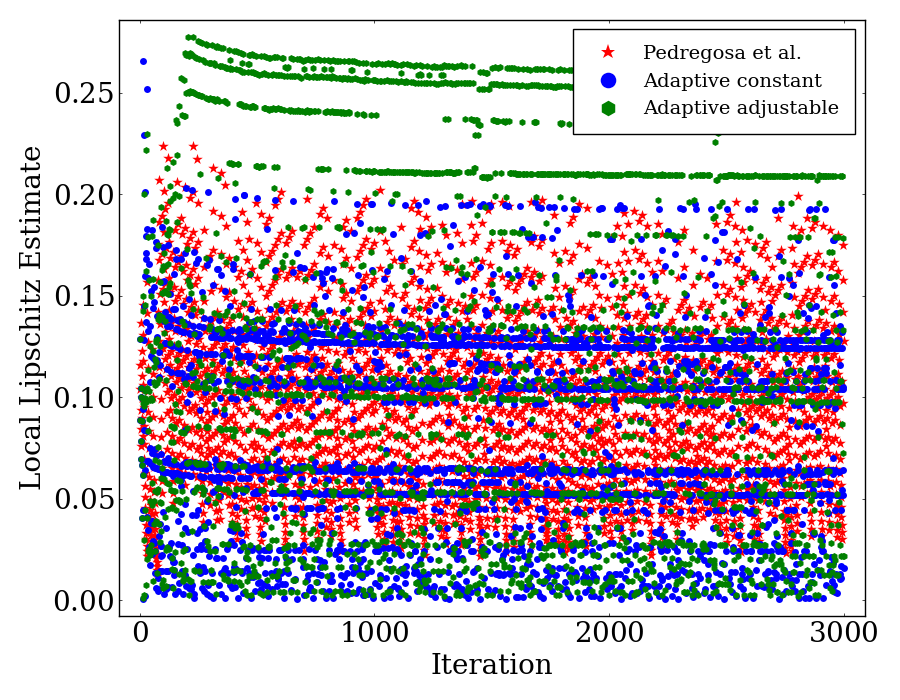

Saved plot: /content/output/Logistic_Regression_a1a_Gap.eps


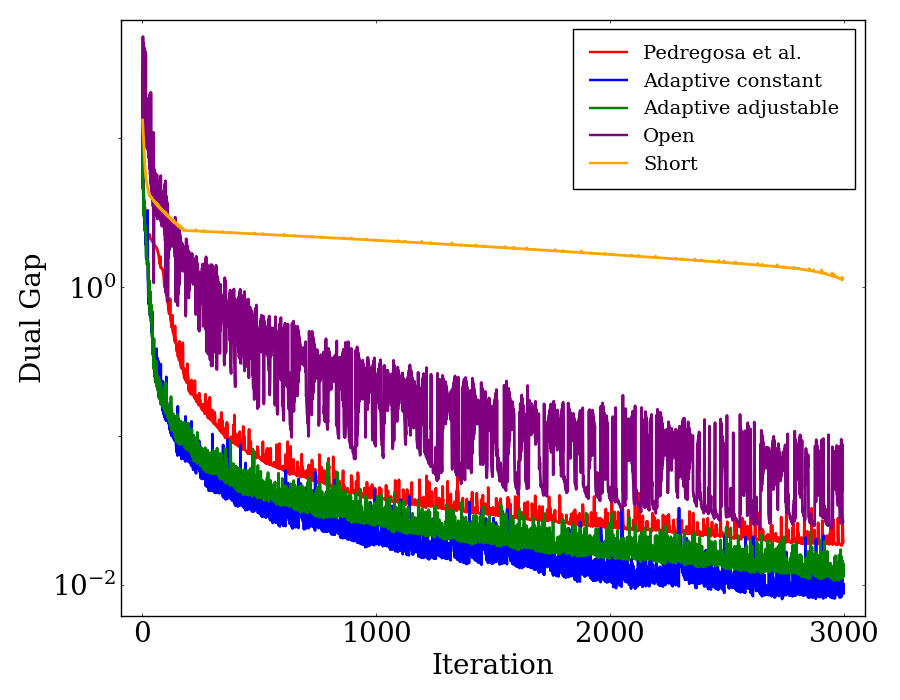

Saved plot: /content/output/Logistic_Regression_a1a_Gap_vs_time.eps


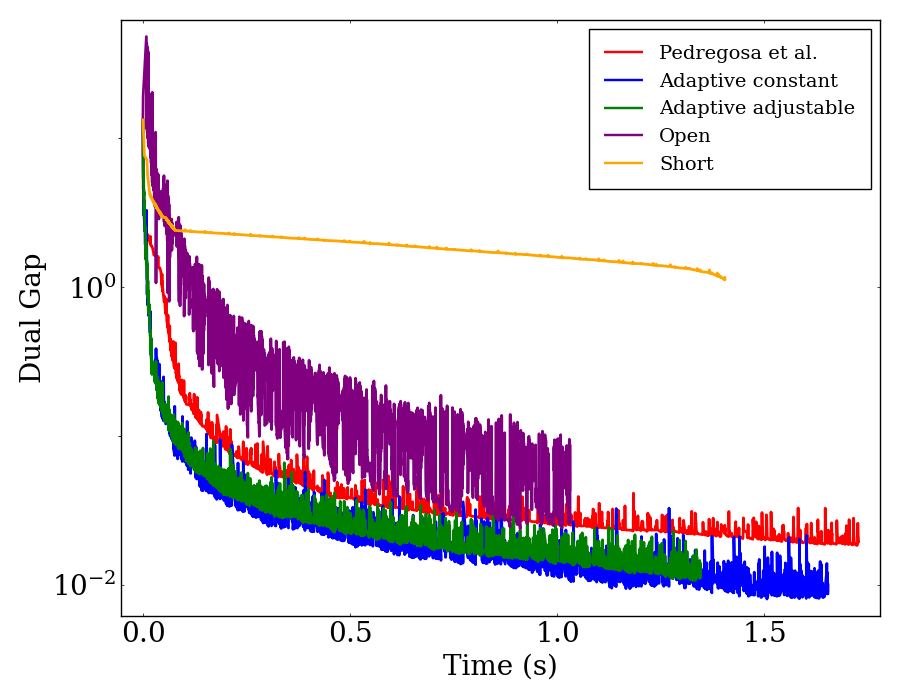

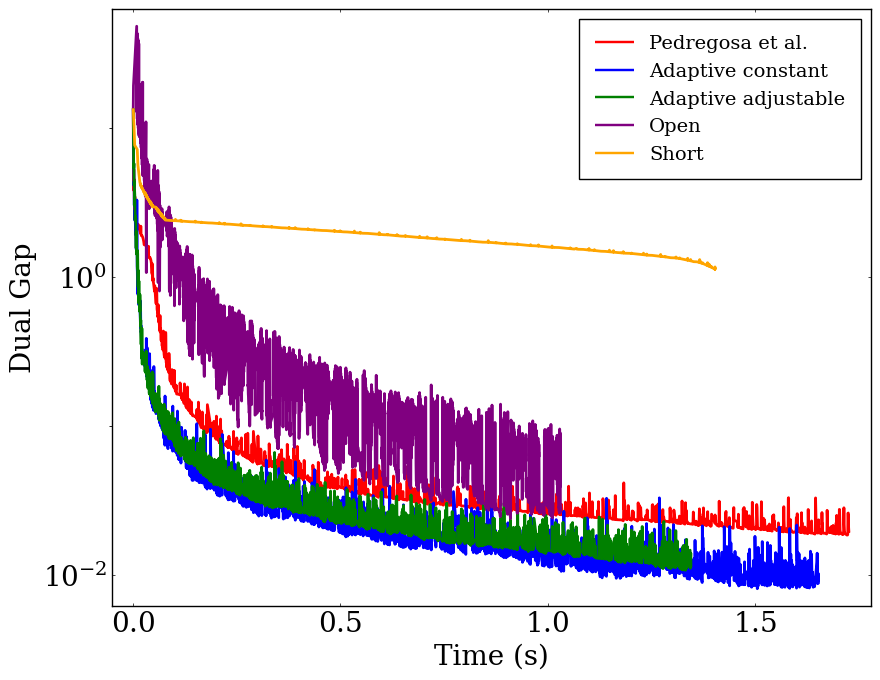

In [14]:
# Ensure all necessary packages are loaded
using DataFrames
using LinearAlgebra
using Statistics
using MAT
using Random
using Plots
using Zygote
using Measures
using PyPlot
using CSV
using Arpack
using Downloads
using SparseArrays
using LIBSVM


our = matread(joinpath(output_dir, "results_FW_OUR.mat"))
our5 = matread(joinpath(output_dir, "results_FW_OUR_5.mat"))
ped = matread(joinpath(output_dir, "results_FW_Pedregosa.mat"))
open = matread(joinpath(output_dir, "results_open.mat"))
short = matread(joinpath(output_dir, "results_L.mat"))
#______________________________________________________________________________#
# Define the output file for the table
println("\n# Summary of Results:")
println("Method             | Iterations | Time     | Objective | Dual Gap   | Backtracking | Max L_k   | Mean L_k")
println("-------------------|------------|----------|-----------|------------|--------------|-----------|----------|")
println("Adaptive constant  | $(length(our["values"]) - 1) | $(round(sum(our["times"]), digits=4)) | $(round(our["values"][end], digits=6)) | $(round(our["gaps"][end], digits=4)) | $(sum(our["backtrack_counts"])) | $(round(maximum(our["L_ks"]), digits=6)) | $(round(mean(our["L_ks"]), digits=6))")
println("Adaptive adjustable| $(length(our5["values"]) - 1) | $(round(sum(our5["times"]), digits=4)) | $(round(our5["values"][end], digits=6)) | $(round(our5["gaps"][end], digits=4)) |  $(sum(our5["backtrack_counts"])) | $(round(maximum(our5["L_ks"]), digits=6)) | $(round(mean(our5["L_ks"]), digits=6))")
println("Pedregosa et al.   | $(length(ped["values"]) - 1) | $(round(sum(ped["times"]), digits=4)) | $(round(ped["values"][end], digits=6)) | $(round(ped["gaps"][end], digits=4)) | $(sum(ped["backtrack_counts"])) | $(round(maximum(ped["L_ks"]), digits=6)) | $(round(mean(ped["L_ks"]), digits=6))")
println("Short              | $(length(short["values"]) - 1) | $(round(sum(short["times"]), digits=4)) | $(round(short["values"][end], digits=6)) | $(round(short["gaps"][end], digits=4)) | -- | -- | --")
println("Open Loop          | $(length(open["values"]) - 1) | $(round(sum(open["times"]), digits=4)) | $(round(open["values"][end], digits=6)) | $(round(open["gaps"][end], digits=4)) | -- | -- | --")
println("\nAll computations and plotting complete. Check $output_dir for results.")
#______________________________________________________________________________#
# Print confirmation to console
println("All computations and plotting complete. Check $output_dir for results.")


#________________________new________Ploting_______________________________________#
function create_and_save_plots()
    # Load data
    our = matread(joinpath(output_dir, "results_FW_OUR.mat"))
    our5 = matread(joinpath(output_dir, "results_FW_OUR_5.mat"))
    ped = matread(joinpath(output_dir, "results_FW_Pedregosa.mat"))
    open = matread(joinpath(output_dir, "results_open.mat"))
    short = matread(joinpath(output_dir, "results_L.mat"))

    # Compute cumulative times
    our_cum_times = [0.0; cumsum(our["times"][2:end])]
    our5_cum_times = [0.0; cumsum(our5["times"][2:end])]
    ped_cum_times = [0.0; cumsum(ped["times"][2:end])]
    open_cum_times = [0.0; cumsum(open["times"][2:end])]
    short_cum_times = [0.0; cumsum(short["times"][2:end])]

    # Define style dictionary based on the template
    style = Dict(:titlefont => (20, "DejaVu Serif"),
                 :guidefont => (20, "DejaVu Serif"),
                 :tickfont => (20, "DejaVu Serif"),
                 :legendfont => (14, "DejaVu Serif"),
                 :grid => false,
                 :framestyle => :box,
                 :margin => 5mm,
                 #:size => (600, 400),
                 :size => (900, 700),
                 :linewidth => 2)

    # Lipschitz Constants (p1) - Unchanged
    p1 = Plots.plot(ped["L_ks"],
                    label="Pedregosa et al.",
                    color=:red,
                    seriestype=:scatter,
                    markersize=8,
                    marker=:star5,
                    markerstrokewidth=0,
                    xlabel="Iteration",
                    ylabel="Local Lipschitz Estimate",
                    titlefont=style[:titlefont],
                    guidefont=style[:guidefont],
                    tickfont=style[:tickfont],
                    legendfont=style[:legendfont],
                    grid=style[:grid],
                    framestyle=style[:framestyle],
                    margin=style[:margin],
                    size=style[:size],
                    linewidth=style[:linewidth],
                    legend=:topright,
                    legendtitle="",
                    legendforegroundcolor=:black,
                    legendbackgroundcolor=:white)

    Plots.plot!(p1, our["L_ks"],
                    label="Adaptive constant",
                    color=:blue,
                    seriestype=:scatter,
                    markersize=5,
                    marker=:circle,
                    markerstrokewidth=0)

    Plots.plot!(p1, our5["L_ks"],
                    label="Adaptive adjustable",
                    color=:green,
                    seriestype=:scatter,
                    markersize=5,
                    marker=:hexagon,
                    markerstrokewidth=0)

    Plots.savefig(p1, joinpath(output_dir, "Logistic_Regression_a1a_L.eps"))
    println("Saved plot: ", joinpath(output_dir, "Logistic_Regression_a1a_L.eps"))
    display(p1)

    # Dual Gap vs Iteration (p2)
    p2 = Plots.plot(ped["gaps"],
                    label="Pedregosa et al.",
                    color=:red,
                  #  linestyle=:dot,
                    markerstrokecolor=:red,
                    markersize=5,
                    yscale=:log10,
                    xlabel="Iteration",
                    ylabel="Dual Gap",
                    titlefont=style[:titlefont],
                    guidefont=style[:guidefont],
                    tickfont=style[:tickfont],
                    legendfont=style[:legendfont],
                    grid=style[:grid],
                    framestyle=style[:framestyle],
                    margin=style[:margin],
                    size=style[:size],
                    linewidth=style[:linewidth],
                    legend=:topright,
                    legendtitle="",
                    legendforegroundcolor=:black,
                    legendbackgroundcolor=:white)

    Plots.plot!(p2, our["gaps"],
                    label="Adaptive constant",
                    color=:blue,
                  #  linestyle=:solid,
                    markerstrokecolor=:blue,
                    markersize=5,
                    linewidth=style[:linewidth])

    Plots.plot!(p2, our5["gaps"],
                    label="Adaptive adjustable",
                    color=:green,
                  #  linestyle=:dash,
                    markerstrokecolor=:green,
                    markersize=5,
                    linewidth=style[:linewidth])

    Plots.plot!(p2, open["gaps"],
                    label="Open",
                    color=:purple,
                 #   linestyle=:dashdot,
                    markerstrokecolor=:purple,
                    markersize=5,
                    linewidth=style[:linewidth])

    Plots.plot!(p2, short["gaps"],
                    label="Short",
                    color=:orange,
                 #   linestyle=:solid,
                    markerstrokecolor=:orange,
                    markersize=5,
                    linewidth=style[:linewidth])

    Plots.savefig(p2, joinpath(output_dir, "Logistic_Regression_a1a_Gap.eps"))
    println("Saved plot: ", joinpath(output_dir, "Logistic_Regression_a1a_Gap.eps"))
    display(p2)


    # Dual Gap vs Time plot (p6)
    p6 = Plots.plot(ped_cum_times[1:end-1],
                    ped["gaps"][1:end],
                    label="Pedregosa et al.",
                    color=:red,
                   # linestyle=:dot,
                    markerstrokecolor=:red,
                    yscale=:log10,
                    xlabel="Time (s)",
                    ylabel="Dual Gap",
                    markersize=5,
                    titlefont=style[:titlefont],
                    guidefont=style[:guidefont],
                    tickfont=style[:tickfont],
                    legendfont=style[:legendfont],
                    grid=style[:grid],
                    framestyle=style[:framestyle],
                    margin=style[:margin],
                    size=style[:size],
                    linewidth=style[:linewidth],
                    legend=:topright,
                    legendtitle="",
                    legendforegroundcolor=:black,
                    legendbackgroundcolor=:white)

    Plots.plot!(p6, our_cum_times[1:end-1],
                    our["gaps"][1:end],
                    label="Adaptive constant",
                    color=:blue,
                  #  linestyle=:solid,
                    markerstrokecolor=:blue,
                    markersize=5,
                    linewidth=style[:linewidth])

    Plots.plot!(p6, our5_cum_times[1:end-1],
                    our5["gaps"][1:end],
                    label="Adaptive adjustable",
                    color=:green,
                   # linestyle=:dash,
                    markerstrokecolor=:green,
                    markersize=5,
                    linewidth=style[:linewidth])

    Plots.plot!(p6, open_cum_times[1:end-1],
                    open["gaps"][1:end],
                    label="Open",
                    color=:purple,
                    #linestyle=:dashdot,
                    markerstrokecolor=:purple,
                    markersize=5,
                    linewidth=style[:linewidth])

    Plots.plot!(p6, short_cum_times[1:end-1],
                    short["gaps"][1:end],
                    label="Short",
                    color=:orange,
                  #  linestyle=:solid,
                    markerstrokecolor=:orange,
                    markersize=5,
                    linewidth=style[:linewidth])

    Plots.savefig(p6, joinpath(output_dir, "Logistic_Regression_a1a_Gap_vs_time.eps"))
    println("Saved plot: ", joinpath(output_dir, "Logistic_Regression_a1a_Gap_vs_time.eps"))
    display(p6)
end

create_and_save_plots()
#______________________________________________________________________________#

In [16]:
# Step 1: Ensure PyCall is installed
# This package allows Julia to call Python functions.
using Pkg
Pkg.add("PyCall")

# Step 2: Zip the output folder
# We run a shell command to compress the '/content/output' directory
# into a single file named 'output.zip'.
println("Zipping the output folder...")
try
    run(`zip -r /content/output.zip /content/output`)
    println("Zipping successful!")
catch e
    println("Error during zipping: ", e)
end


# Step 3: Download the created zip file
# We use PyCall to access Google Colab's Python library for downloading files.
println("Preparing to download...")
using PyCall

try
    # Import the Python module "google.colab.files"
    @pyimport google.colab.files as colab_files

    # Trigger the browser download for the zip file
    println("Please check your browser to confirm the download.")
    colab_files.download("/content/output.zip")
catch e
    println("Error during download: ", e)
    println("Please ensure you are running this in a Google Colab environment.")
end

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


Zipping the output folder...
updating: content/output/ (stored 0%)
updating: content/output/Logistic_Regression_a1a_Gap.eps (deflated 57%)
updating: content/output/results_FW_OUR_5.mat (deflated 36%)
updating: content/output/data.mat (deflated 99%)
updating: content/output/Logistic_Regression_a1a_Gap_vs_time.eps (deflated 58%)
updating: content/output/Logistic_Regression_a1a_L.eps (deflated 62%)
updating: content/output/results_FW_OUR.mat (deflated 35%)
updating: content/output/results_open.mat (deflated 35%)
updating: content/output/results_L.mat (deflated 28%)
updating: content/output/results_FW_Pedregosa.mat (deflated 36%)
Zipping successful!
Preparing to download...


LoadError: syntax: unsupported `const` declaration on local variable around /root/.julia/packages/PyCall/1gn3u/src/PyCall.jl:602